In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('dark_background')

In [2]:
def get_data(steam_id,name):
    response = requests.get(f'https://royale.pet/api/player/{str(steam_id)}/stats')
    if response.status_code == 404:
        print('Error 404!')
        df = pd.DataFrame()
    else:
        # get data
        keys=[]
        groups=[]
        values=[]
        for key in response.json()['stats'].keys():
            keys.append(key)
            groups.append(response.json()['stats'][key]['group'])
            values.append(response.json()['stats'][key]['value'])
        # translate to pandas format
        dd = {'keys':keys,'groups':groups,'values':values,'name':name}
        # build df
        df = pd.DataFrame(dd)
        df = df.sort_values(by='groups')
        response.close()

    return df


def load_data_classic():
    '''
    the old way to load all the data from scratch
    
    doesn't depend on having saved a database before
    '''

    id_list = load_ids()

    dfs = []

    for iiii in tqdm(id_list):
        dfs.append(get_data(iiii,str(iiii)))
        
    return pd.concat(dfs)

def load_data():
    id_list = load_ids()
    
    # load most recent data dump
    db = pd.read_csv('data/db.csv')
    # i hate pandas sometimes
    db = db.iloc[: , 1:]
    existant = db['name'].unique()
    
    # get new ids from id_list
    # [i for i, e in enumerate(l1) if e in l2]
    new_ids = [e for i, e in enumerate(id_list) if e not in existant]
    
    dfs = []
    for iiii in tqdm(new_ids):
        dfs.append(get_data(iiii,str(iiii)))

    merged_new = pd.concat(dfs)
    
    merged = pd.concat([db,merged_new])
    
    ## save this newly merged data frame
    merged.to_csv('data/db.csv')
    
    return merged
    
    
def load_ids():
    
    ids = []
    with open('data/ids.txt','r') as f:
        for l in f:
            ids.append(int(l[:-1]))
    
    return ids

def get_our_current_maxes(aa,oo):
    m=[]
    for ss in oo:
        m.append(np.round(np.max(aa.loc[aa['keys']==ss]['values']),10))

    # check for nans
    for i,j in enumerate(m):
        if np.isnan(j):
            m[i] = -999999
        
    return m
    
    
def get_our_current_stats():
    df_gre = get_data(steam_id=76561199037603294,name='green')
    df_red = get_data(steam_id=76561198869827899,name='red')
    df_pin = get_data(steam_id=76561199037577176,name='pink')
    dfs = [df_gre, df_red, df_pin]
    aa = pd.concat(dfs)
    
    return aa

def plot_histograms(df):
    fig, axes = plt.subplots(nrows=11,ncols=11,figsize=(40,35))

    k = df['keys'].unique()
    # load in our data
    our_stats = get_our_current_stats()
    c = 0
    maxes=get_our_current_maxes(our_stats,k)
    fac = 4
    for i in range(11):
        for j in range(11):
            rr = (df.loc[df['keys'] == k[c]]['values'].min(),fac*maxes[c])
            if rr[1] < rr[0]:
                rr = (df.loc[df['keys'] == k[c]]['values'].min(),df.loc[df['keys'] == k[c]]['values'].max())
            if rr[1] == fac*-9999999:
                rr = (df.loc[df['keys'] == k[c]]['values'].min(),df.loc[df['keys'] == k[c]]['values'].max())
            axes[i,j].hist(df.loc[df['keys'] == k[c]]['values'], bins=20, 
                           range=rr,
                           color=plt.get_cmap('rainbow')(c/121),
                           edgecolor='w',alpha=0.66)
            for name,c_name in zip(['green','red','pink'],['lime','red','magenta']):
                xval = our_stats.loc[((our_stats['keys'] == k[c]) & (our_stats['name'] == name))]['values']
                if xval.empty:
                    pass
                else:
                    xval = float(xval)
                    axes[i,j].axvline(x=xval, color=c_name,lw=4)
            axes[i,j].set_title(k[c])
            axes[i,j].grid(False)
            c+=1
    plt.tight_layout()
    count = len(df['name'].unique())
    fig.suptitle(f'$n_{{accounts}}={count}$',fontsize=24,y=1.02)
    plt.savefig('figures/figure.png',dpi=300,bbox_inches='tight')
    
def plot_win_percetanges_histograms(df):
    fig, axes = plt.subplots(nrows=11,ncols=11,figsize=(40,35))

    k = df['keys'].unique()
    # load in our data
    our_stats = get_our_current_stats()
    c = 0
    maxes=get_our_current_maxes(our_stats,k)
    fac = 4
    for i in range(11):
        for j in range(11):
            rr = (df.loc[df['keys'] == k[c]]['values'].min(),fac*maxes[c])
            if rr[1] < rr[0]:
                rr = (df.loc[df['keys'] == k[c]]['values'].min(),df.loc[df['keys'] == k[c]]['values'].max())
            if rr[1] == fac*-9999999:
                rr = (df.loc[df['keys'] == k[c]]['values'].min(),df.loc[df['keys'] == k[c]]['values'].max())
            axes[i,j].hist(df.loc[df['keys'] == k[c]]['values'], bins=20, 
                           range=rr,
                           color=plt.get_cmap('rainbow')(c/121),
                           edgecolor='w',alpha=0.66)
            for name,c_name in zip(['green','red','pink'],['lime','red','magenta']):
                xval = our_stats.loc[((our_stats['keys'] == k[c]) & (our_stats['name'] == name))]['values']
                if xval.empty:
                    pass
                else:
                    xval = float(xval)
                    axes[i,j].axvline(x=xval, color=c_name,lw=4)
            axes[i,j].set_title(k[c])
            axes[i,j].grid(False)
            c+=1
    plt.tight_layout()
    count = len(df['name'].unique())
    fig.suptitle(f'$n_{{accounts}}={count}$',fontsize=24,y=1.02)
    plt.savefig('figures/figure.png',dpi=300,bbox_inches='tight')
    

In [3]:
merged = load_data()

100%|███████████████████████████████████████| 184/184 [03:29<00:00,  1.14s/it]


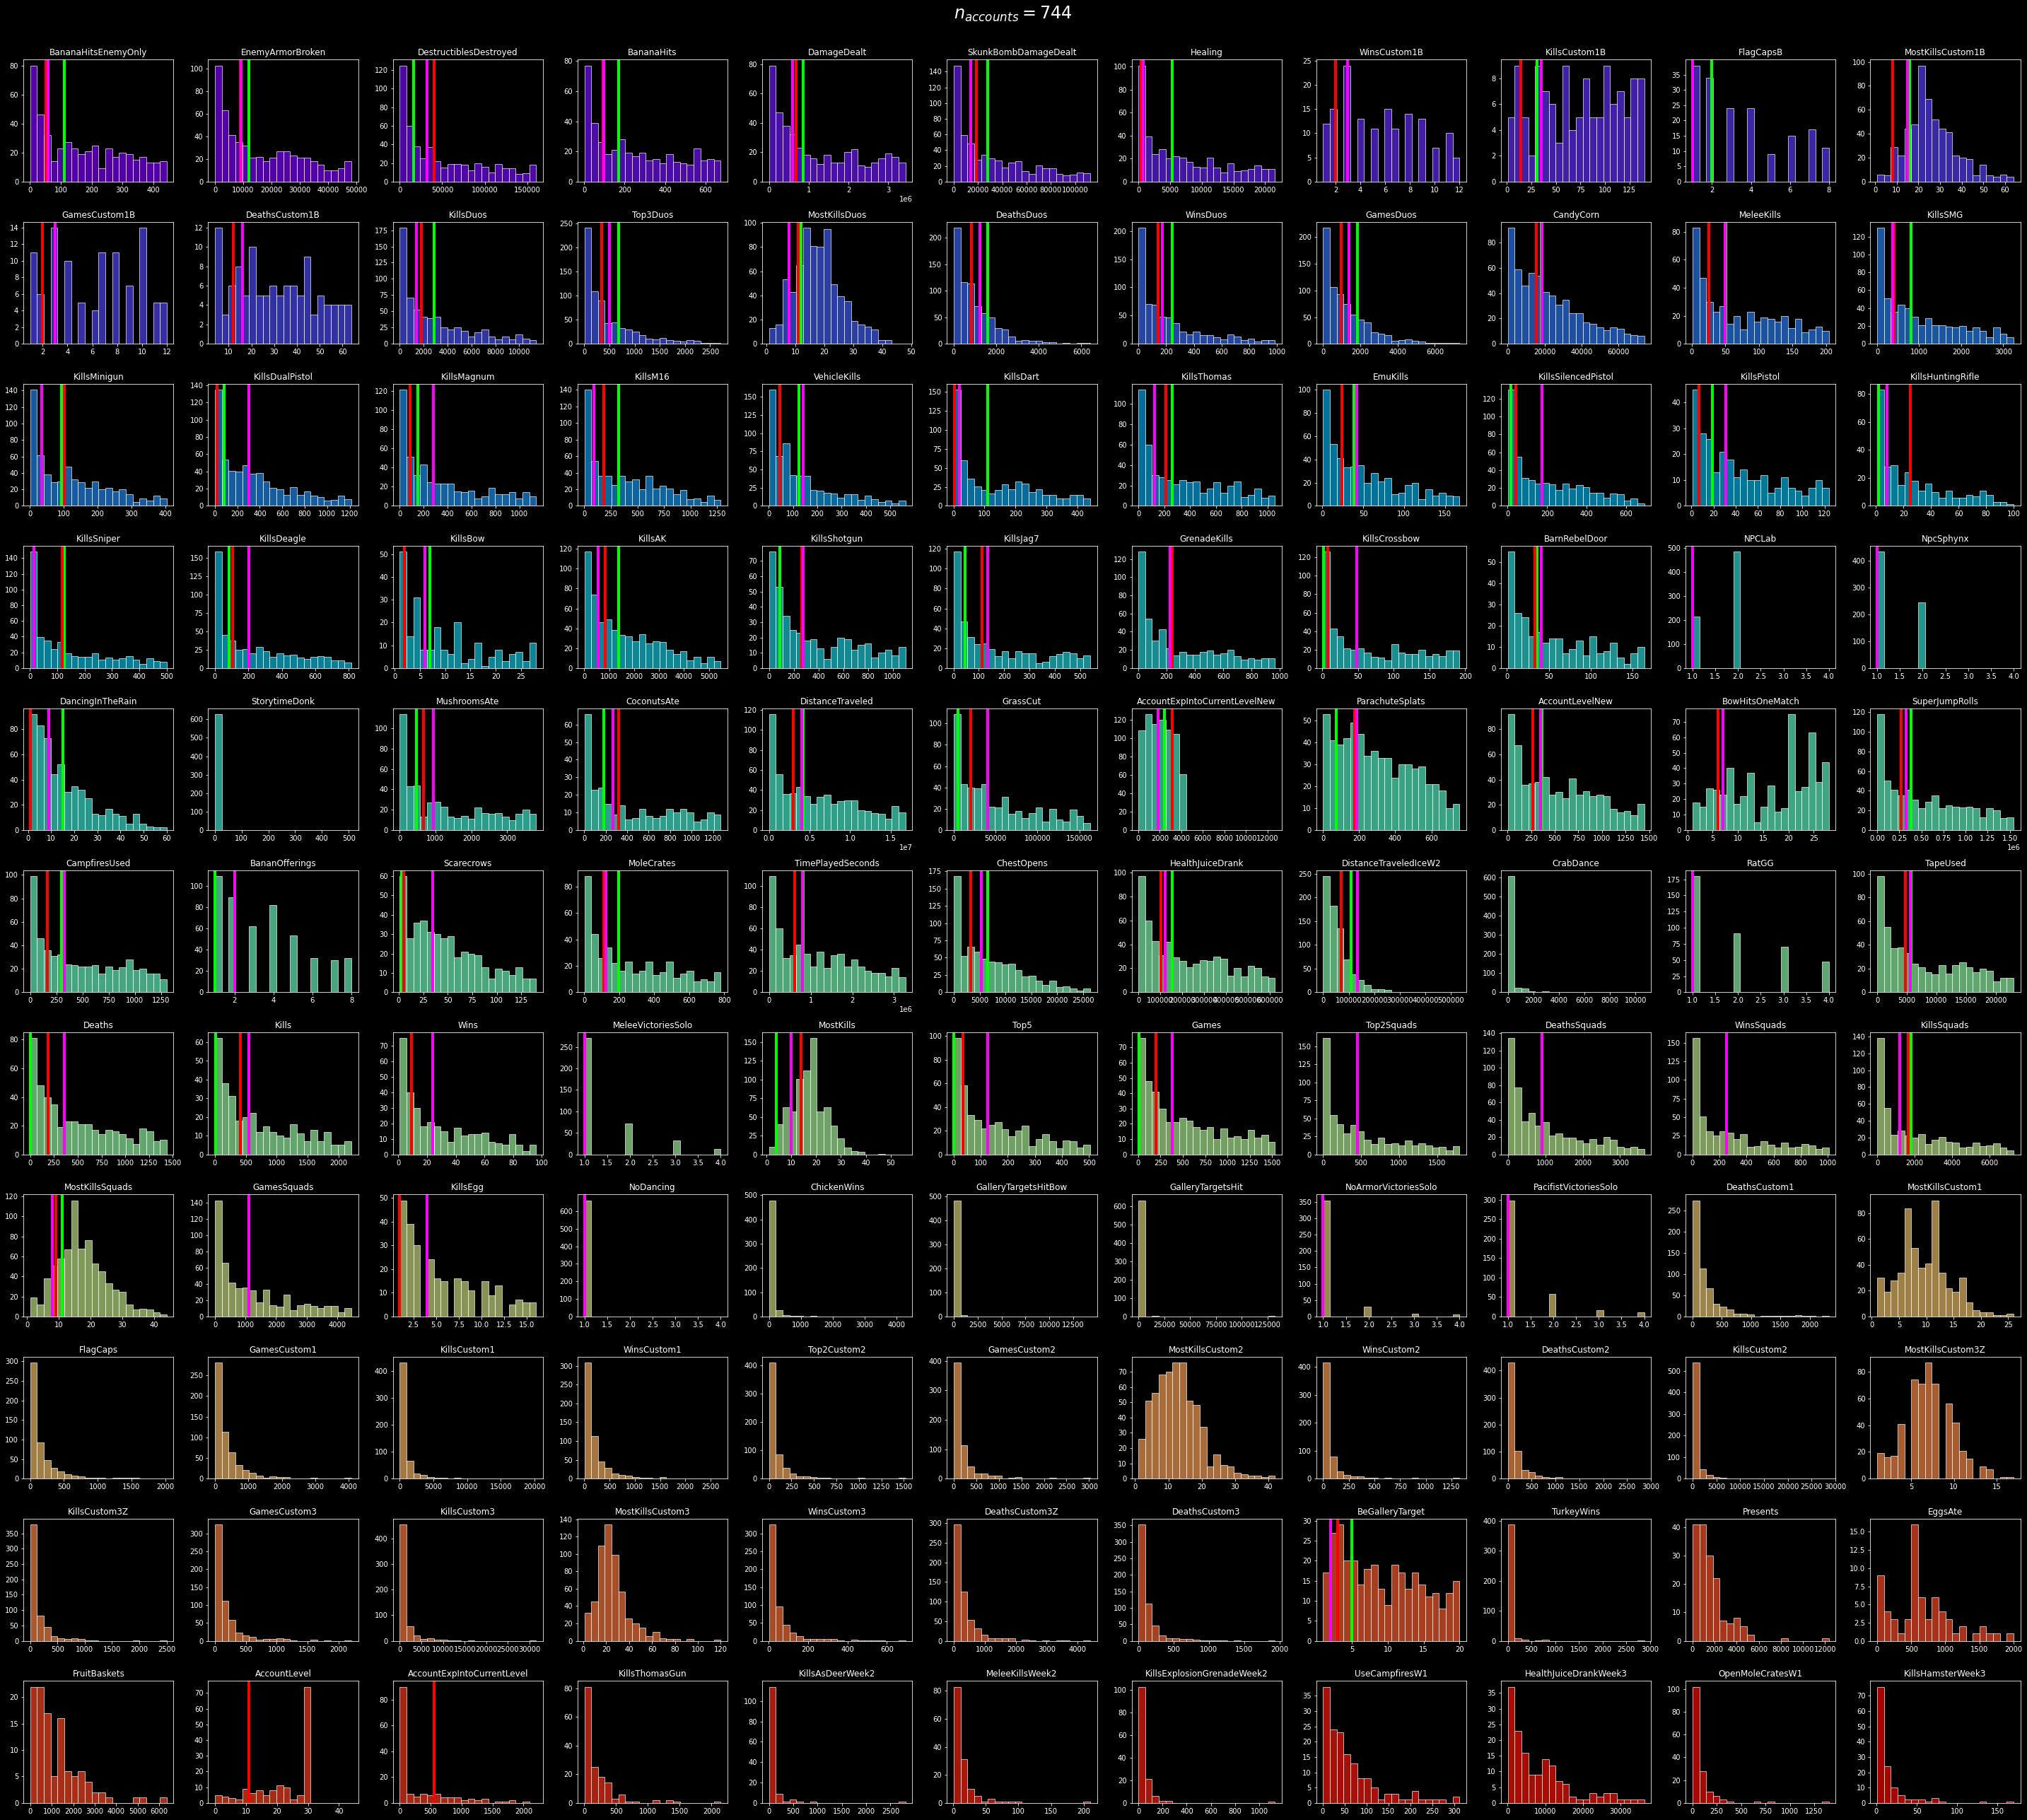

In [4]:
plot_histograms(merged)